## Analysis of movement during different conditions
- Comparing the CS+US vs. CS+ and CS- in movement


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

import pingouin as pg
import pymc3 as pm
import arviz as az

/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
df2 = pd.read_csv('data/fdData.csv')

In [4]:
pg.rm_anova(data=df2, dv='fd', within='cond', subject='subject')

,Source,ddof1,ddof2,F,p-unc,np2,eps
0,cond,2,128,2.285206,0.10589,0.034475,0.622016


In [6]:
df2.groupby('cond').describe()

fd                                                              \
     count      mean       std       min       25%       50%       75%   
cond                                                                     
CS    65.0  0.166985  0.092822  0.061886  0.107435  0.141123  0.193194   
CSm   65.0  0.179450  0.114984  0.064717  0.116680  0.142291  0.206081   
US    65.0  0.178781  0.108516  0.069305  0.118852  0.147927  0.207947   

                
           max  
cond            
CS    0.582391  
CSm   0.721009  
US    0.715791

<AxesSubplot:xlabel='cond', ylabel='fd'>

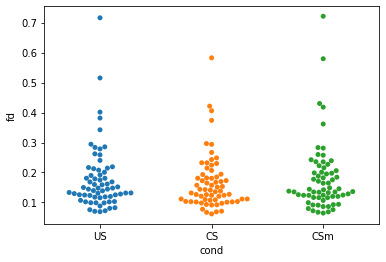

In [7]:
sns.swarmplot(x='cond', y='fd', data=df2)

No difference between the different conditions.

# Bayesian analysis

In [8]:
df2['subject'] = df2['subject'].astype('category')
#df['condition'] = df['condition'].astype('category')

n_sub = len(df2['subject'].unique())
subIDX = df2['subject'].cat.codes.values
# condition
n_cond = len(df2['cond'].unique())
#condIDX = df['condition'].cat.codes.values

# trialNo
y = df2['fd'].values

df2['cond'] = df2['cond'].astype('category')
# generating condition index
condIDX = df2.cond.cat.codes.values

In [9]:
with pm.Model() as model1:
    
    
    mu_a = pm.Normal('mu_a', mu=0, sigma=.5)
    sigma_a = pm.HalfCauchy('sigma_a', .5)
    a_matt = pm.Normal('a_matt', mu=0, sd=1, shape=n_sub)
    a = pm.Deterministic('a', mu_a + sigma_a*a_matt)
    
    mu_b = pm.Normal('mu_b', mu=0, sigma=.5)
    sigma_b = pm.HalfCauchy('sigma_b', .5)
    b_matt = pm.Normal('b_matt', mu=0, sigma=1, shape=n_cond)
    b_cond = pm.Deterministic('b_cond', mu_b + sigma_b*b_matt)
     
  
    eps = pm.HalfCauchy('eps', .5)
    
    # make mu a determenistic distribution so we can test later vs. actual data
    
    mu = pm.Deterministic('mu',a[subIDX] + b_cond[condIDX])
    
    y_hat = pm.Normal('y_hat', mu=mu, sigma=eps, observed=y)
    
    trace = pm.sample(target_accept=.95, chains=4, cores=10, return_inferencedata=True, draws=2000, tune=2000)    


KeyboardInterrupt



In [ ]:
az.summary(trace, var_names=['mu_a','mu_b'], hdi_prob=.95)

In [11]:
# stacking
trStacked = trace.posterior.stack(draws=('chain','draw'))

In [12]:
csminus = trStacked.b_cond[0,:].values
csplus = trStacked.b_cond[1,:].values
csPlusUS = trStacked.b_cond[2,:].values
csall = np.mean(np.stack([csminus, csplus]), axis=0) # averaging across CSs
usVcs = csPlusUS - csall

Text(0.5, 1.0, 'CSPlusUS-CS Movement')

<Figure size 1296x216 with 0 Axes>

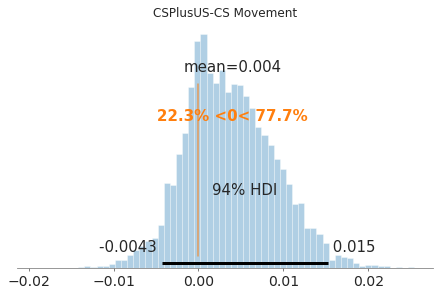

In [13]:
sns.set_style('ticks')
fig = plt.figure(figsize=(18,3))
az.plot_posterior(usVcs, point_estimate='mean', kind='hist', ref_val=0).set_title("CSPlusUS-CS Movement")


In [14]:
sum(usVcs > 0) / 8000

0.777

In [15]:
print(f'Standardized coeficient {np.mean(usVcs) / np.std(usVcs)}')
az.summary(usVcs, hdi_prob=0.95)

arviz - WARNING - Shape validation failed: input_shape: (1, 8000), minimum_shape: (chains=2, draws=4)


Standardized coeficient 0.7649035755620005


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,0.004,0.005,-0.005,0.015,0.0,0.0,5948.0,7452.0,NaN
